In [11]:
import pandas as pd
import json
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 14})

In [2]:
with open("old.json") as f:
    data_old = pd.DataFrame(json.load(f))

with open("new.json") as f:
    data_new = pd.DataFrame(json.load(f))

with open("true.json") as f:
    data_true = pd.DataFrame(json.load(f))

data_new

db_id       n          mean         p50  \
0    0003bc0f-a56b-46dd-88ef-4f4af7c4fa0e   19030  6.991069e+03        5850   
1    0162019d-1392-4282-94dc-ccd8af865091  227058  7.372477e+08   542608675   
2    01e63fb7-d03a-48f6-81e0-da298bccffff   33865  1.581308e+06        5500   
3    024c99b9-76e9-41e4-93c5-d4bef42dcc88  998000  1.072687e+08   112249789   
4    02525540-0a5d-45aa-9d06-3c09279c2e03   84874  7.972378e+03         263   
..                                    ...     ...           ...         ...   
234  f91045cd-5a5e-40ba-8528-8b9f6b042cc3   31177  3.449082e+05        6467   
235  f9cb760b-98d5-45e7-aa06-9f95f5adf74f   42039  1.559352e+02         190   
236  fb3bad41-841c-4500-b5f9-2541e49843d4  111245  1.175375e+06      146271   
237  fb4cff31-3428-457d-88e7-6380ff4e5cbc   41968  1.561034e+02         190   
238  ffe6c5f4-d6d1-46d0-9d82-d6ebbdee612a  216165  1.989279e+09  1921184769   

            p90         p99  
0         14792       20284  
1    1774737577  2008474072  
2       5480150     7208593  
3     165866762   193259076  
4         16600       81721  
..          ...         ...  
234     1059319     4662179  
235         253         402  
236     3331381    15408253  
237         254         396  
238  3917288234  4224825423  

[239 rows x 6 columns]

In [24]:
num_queries = data_new["n"].values
total = np.sum(num_queries)
for metric in ["mean", "p50", "p90", "p99"]:
    print(f"{metric} latency-------------")
    true_m = np.dot(data_true[metric].values, num_queries)/total
    print("true: ", true_m)
    new_m = np.dot(data_new[metric].values, num_queries)/total
    print("new: ", new_m)
    old_m = np.dot(data_old[metric].values, num_queries)/total
    print("old: ", old_m)

mean latency-------------
true:  412066599.17238307
new:  529589928.04798144
old:  573028472.7479241
p50 latency-------------
true:  205133383.44565573
new:  446668675.7271896
old:  497080244.3120751
p90 latency-------------
true:  1146020110.250041
new:  1201833880.334207
old:  1286517254.810462
p99 latency-------------
true:  1438122964.985149
new:  1460676209.2499447
old:  1456329796.6339204


In [ ]:
data_old

In [27]:
oracle = data_true[["n", "mean", "p50", "p90"]].median()
oracle

n        45995.000000
mean    129799.015506
p50       2088.000000
p90      74018.000000
dtype: float64

In [28]:
old_pred = data_old[["n", "mean", "p50", "p90"]].median()
old_pred

n        45995.000000
mean    233287.052172
p50       5189.000000
p90     162665.000000
dtype: float64

In [29]:
new_pred = data_new[["n", "mean", "p50", "p90"]].median()
new_pred

n        45995.000000
mean    185923.425982
p50       4339.000000
p90     138490.000000
dtype: float64

In [30]:
for metric in ["mean", "p50", "p90"]:
    t_p = (old_pred[metric] - oracle[metric])/old_pred[metric]
    s_p = (old_pred[metric] - new_pred[metric])/old_pred[metric]
    print(f"Percentage improvement on {metric} is true: {t_p}; stage {s_p};")

Percentage improvement on mean is true: 0.4436081458533563; stage 0.20302723939731881;
Percentage improvement on p50 is true: 0.5976103295432647; stage 0.16380805550202351;
Percentage improvement on p90 is true: 0.5449666492484554; stage 0.1486183260074386;


In [31]:
df = pd.DataFrame({"Existing predictor": old_pred, "Stage predictor": new_pred, "Optimal": oracle})
df = df.drop("n") / 1000

/tmp/ipykernel_2923/568657641.py:5: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, 5000)


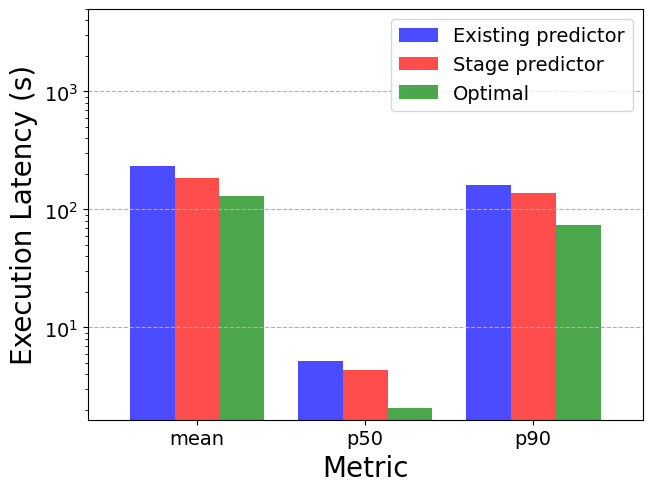

In [55]:
fig, ax = plt.subplots(1, 1, constrained_layout=True)
df.plot.bar(ax=ax, rot=0, width=0.8, color=["blue", "red", "green"], alpha=0.7)
ax.set_yscale("log")
ax.grid(axis="y", ls="--")
ax.set_ylim(0, 5000)
ax.set_ylabel("Execution Latency (s)", fontsize=20)
ax.set_xlabel("Metric", fontsize=20)
fig.savefig("e2e_performance.pdf")

In [8]:
old_mean = data_old["mean"].values
new_mean = data_new["mean"].values
true_mean = data_true["mean"].values
new_improve = (old_mean-new_mean)/old_mean
true_improve = (old_mean-true_mean)/old_mean

In [19]:
idx = np.argsort(true_improve[true_improve > 0])

In [45]:
len(idx)/4

47.75

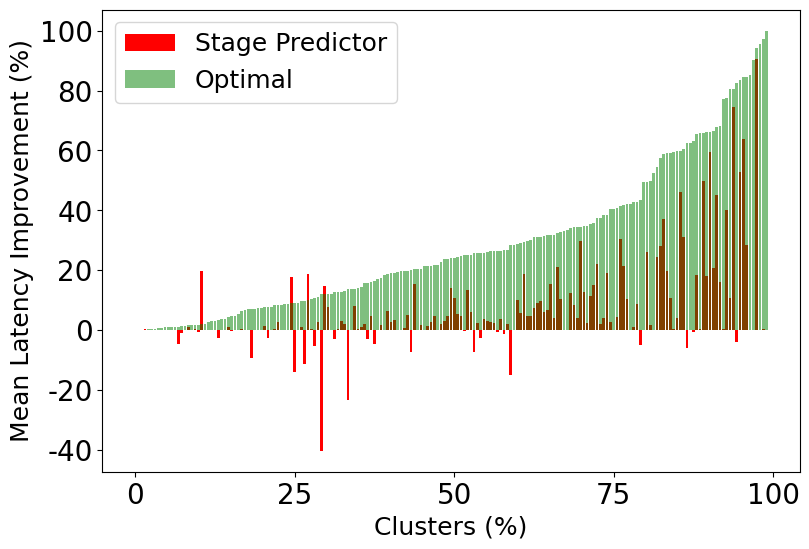

In [61]:
plt.figure(figsize = (9,6))
plt.bar(np.arange(len(idx)), new_improve[true_improve > 0][idx], color="red", label="Stage Predictor")
plt.bar(np.arange(len(idx)), true_improve[true_improve > 0][idx], alpha=0.5, color="green", label="Optimal")

plt.yticks(ticks=[-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0], labels=[-40, -20, 0, 20, 40, 60, 80, 100], fontsize=20)
plt.xticks(ticks=[0, 48, 96, 144, 192], labels=[0, 25, 50, 75, 100], fontsize=20)
plt.xlabel("Clusters (%)", fontsize=18)
plt.ylabel("Mean Latency Improvement (%)", fontsize=18)
plt.legend(fontsize=18)
plt.savefig("e2e_instances.pdf")

<BarContainer object of 239 artists>

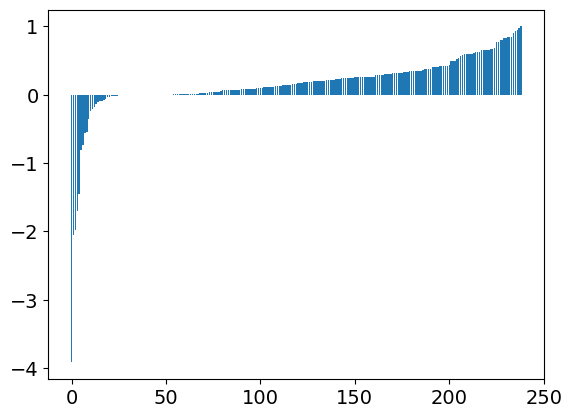

In [15]:
plt.bar(np.arange(239), np.sort(true_improve))